# **Downloaded Historical Stock Data**

In [2]:
import yfinance as yf

tickers = ['AAPL', 'TSLA', 'AMZN', 'GOOG', 'MSFT']
data = {ticker: yf.download(ticker, start='2015-01-01', end='2025-01-01') for ticker in tickers}


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


# **Pre process Data**

In [3]:
import pandas as pd

df = data['AAPL'].copy()
df = df.fillna(method='ffill')


<ipython-input-3-0826b7e27982>:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


# **Calculate Financial Indicators**

In [6]:
import pandas as pd

def calculate_indicators(df, close_col='Close'):
    # --- Simple Moving Average (SMA)
    df['SMA_20'] = df[close_col].rolling(window=20).mean()

    # --- Exponential Moving Average (EMA)
    df['EMA_20'] = df[close_col].ewm(span=20, adjust=False).mean()

    # --- Bollinger Bands
    rolling_std = df[close_col].rolling(window=20).std()
    df['BB_upper'] = df['SMA_20'] + 2 * rolling_std
    df['BB_lower'] = df['SMA_20'] - 2 * rolling_std

    # --- Relative Strength Index (RSI)
    delta = df[close_col].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))

    return df


# **Unsupervised Anamoly Detection**

In [18]:
import yfinance as yf
import pandas as pd
from sklearn.ensemble import IsolationForest

# Step 1: Download Stock Data
df = yf.download("AAPL", start="2020-01-01", end="2025-01-01")

# Step 2: Flatten the MultiIndex columns to a single-level column
df.columns = df.columns.get_level_values(0)  # Only keep the 'Price' level from MultiIndex

# Step 3: Calculate indicators (SMA, EMA, Bollinger Bands, RSI)
def calculate_indicators(df, close_col='Close'):
    close = df[close_col]

    # 20-period Simple Moving Average (SMA)
    df['SMA_20'] = close.rolling(window=20).mean()

    # 20-period Exponential Moving Average (EMA)
    df['EMA_20'] = close.ewm(span=20, adjust=False).mean()

    # Bollinger Bands (upper and lower)
    rolling_std = close.rolling(window=20).std()
    df['BB_upper'] = df['SMA_20'] + 2 * rolling_std
    df['BB_lower'] = df['SMA_20'] - 2 * rolling_std

    # Relative Strength Index (RSI)
    delta = close.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))

    return df

# Apply the indicator function to calculate indicators
df = calculate_indicators(df)

# Step 4: Select relevant columns and drop rows with NaN values
features = df[['Close', 'SMA_20', 'EMA_20', 'RSI']].dropna()

# Step 5: Perform anomaly detection using Isolation Forest
model = IsolationForest(contamination=0.01)
anomalies = model.fit_predict(features)

# Step 6: Map anomaly predictions back to the original DataFrame
# Ensure the anomaly predictions are mapped to the rows with NaN values dropped
df['anomaly_if'] = None  # Initialize the anomaly column with NaN for all rows
df.loc[features.index, 'anomaly_if'] = anomalies  # Assign anomalies only to rows that were used for prediction

# Step 7: Display anomalies in the data
print(df[['Close', 'SMA_20', 'EMA_20', 'RSI', 'anomaly_if']].tail())


[*********************100%***********************]  1 of 1 completed


Price            Close      SMA_20      EMA_20        RSI anomaly_if
Date                                                                
2024-12-24  257.916443  246.023002  246.397574  76.180657         -1
2024-12-26  258.735504  247.219685  247.572615  76.812079         -1
2024-12-27  255.309296  248.251551  248.309441  69.300685         -1
2024-12-30  251.923019  248.994234  248.653592  58.382055         -1
2024-12-31  250.144974  249.535140  248.795628  53.982582         -1


# **Time-Series Forecasting Model (LSTM or Prophet)**

In [19]:
from prophet import Prophet

prophet_df = df.reset_index()[['Date', 'Close']].rename(columns={'Date': 'ds', 'Close': 'y'})
m = Prophet()
m.fit(prophet_df)
future = m.make_future_dataframe(periods=30)
forecast = m.predict(future)


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr1bcq8d8/it1axmab.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr1bcq8d8/xa55o0fm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98469', 'data', 'file=/tmp/tmpr1bcq8d8/it1axmab.json', 'init=/tmp/tmpr1bcq8d8/xa55o0fm.json', 'output', 'file=/tmp/tmpr1bcq8d8/prophet_modelxidm2ezs/prophet_model-20250505111713.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:17:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:17:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


# **Visualize Detected Anomalies**

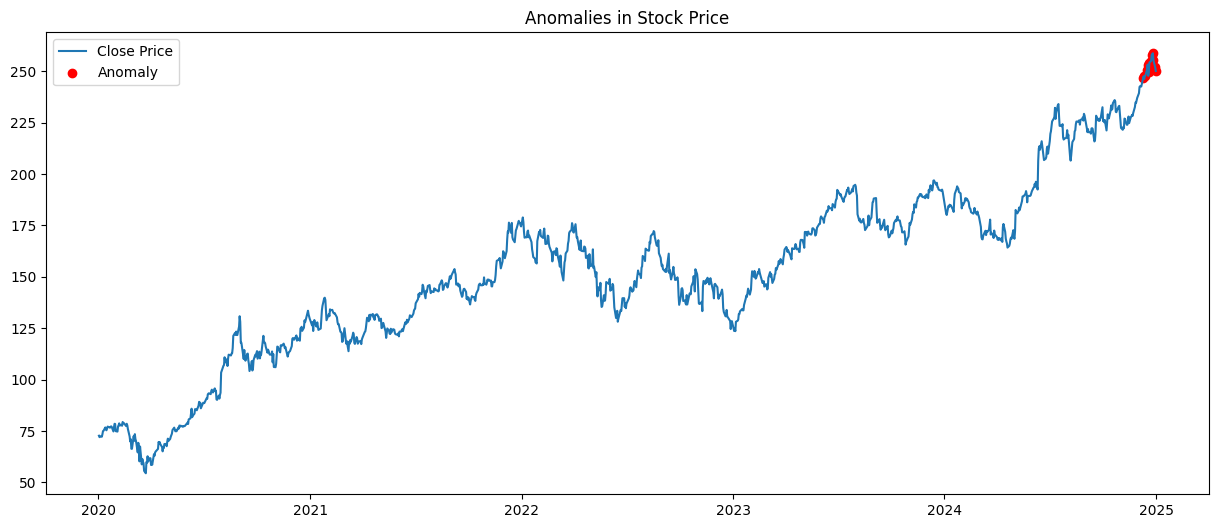

In [20]:

import matplotlib.pyplot as plt

plt.figure(figsize=(15,6))
plt.plot(df['Close'], label='Close Price')
plt.scatter(df[df['anomaly_if'] == -1].index, df[df['anomaly_if'] == -1]['Close'], color='red', label='Anomaly')
plt.title('Anomalies in Stock Price')
plt.legend()
plt.show()
